In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid

% matplotlib inline

In [8]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [9]:
direct='./nd-twins-0006/faces/'

In [10]:
#read metadata and construct scv for DataLoader
df=pd.read_csv('./image-metadata-3.0.csv')
df_relation=pd.read_csv('./twins-relationship-info.csv')

In [16]:
class TwinsDataloader(Dataset):
    def __init__(self, dataroot, df_img, df_relations, transform):
        '''
        dataroot: path to folder with items
        df: pandas dataframe matadata(hasn't been changed)
        df_relatinos: pandas dataframe with relations between classes
        transform: torchvision flip and notflip transforms for  images(dict)
        '''
        self.dataroot = dataroot
        self.df = df[df[' yaw']==0]
        self.transform = transform
        self.relations=df_relations
        self.list_notexist=[]
    def __getitem__(self, index):
        
        def get_img_path(img_id):
            return self.dataroot+f'{img_id[:5]}/{img_id[:-4]}__face.jpg'
        
        monetochka=np.random.randint(0,2)
        #print(monetochka)
        id_a = self.df['filename'].iloc[index]
        img_a = Image.open(get_img_path(id_a))
        
        if monetochka==0: 
            find_id=self.relations['subject_id1'].str.find(id_a[:5])
            #print(find_id[find_id!=-1].index.tolist())
            if find_id[find_id!=-1].index.tolist():               
                id_b=self.relations['subject_id2'].iloc[find_id[find_id!=-1].index].values
                relation=self.relations['relationship_type'].iloc[find_id[find_id!=-1].index].values


                if relation[0] in ['Fraternal','Identical','IdenticalMirror','IdenticalTriplet']:
                    flag='Twins'
                    find_id=self.df['filename'].str.find(str(id_b[0][4:]))
                    id_b=self.df['filename'].loc[find_id[find_id!=-1].index[np.random.randint(0,len(find_id[find_id!=-1].index))]]
                    img_b = Image.open(get_img_path(id_b))
                    img_b=self.transform['notflip'](img_b)
                else:
                    id_b=id_a
                    img_b=img_a.copy()
                    img_b=self.transform['flip'](img_b)
                    flag='Not Twins'
            else:
                id_b=id_a
                img_b=img_a.copy()
                img_b=self.transform['flip'](img_b)
                flag='Not Twins'
        else:
            id_b=id_a
            img_b=img_a.copy()
            img_b=self.transform['flip'](img_b)
            flag='Not Twins'
    
        img_a = self.transform['notflip'](img_a)

        id_a=id_a[:5]
        id_b=id_b[:5]
        return {'img_a': img_a, 'img_b': img_b, 'class_a':id_a,'class_b':id_b,'label':flag}

    def __len__(self):
        return self.df.shape[0]

In [17]:
data_transforms = {
    'flip': transforms.Compose([
            transforms.Resize(224),
            #transforms.TenCrop(0, vertical_flip=True),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'notflip': transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
}

In [18]:
twins_dataset = TwinsDataloader(direct, df,df_relation ,data_transforms)
dataset = DataLoader(twins_dataset, batch_size=5,shuffle=True)

## Check work of dataloader

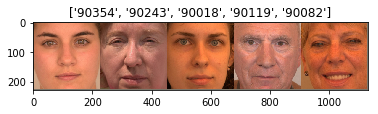

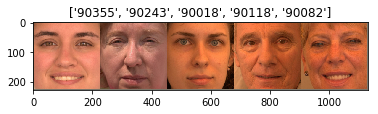

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
T = next(iter(dataset))

# Make a grid from batch
out = torchvision.utils.make_grid(T['img_a'])
imshow(out, title=[x for x in T['class_a']])

out = torchvision.utils.make_grid(T['img_b'])
imshow(out, title=[x for x in T['class_b']])

## Load and define the model

In [20]:
from model import MobileFaceNet

model = MobileFaceNet(embedding_size=512)

PATH = os.path.join(os.getcwd(),"./model_mobilefacenet.pth")

checkpoint = torch.load(PATH,map_location=device)

model.load_state_dict(checkpoint)

In [21]:

class ModelBottom(nn.Module):
    def __init__(self, original_model):
        super(ModelBottom, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-2])
        
    def forward(self, x):
        output = self.features(x)
        return output

#define model and fix hidden features size
model_flatten = ModelBottom(model)
outputs = model_flatten(T['img_a'])
hid_size=outputs.data.shape[1]

#define n_classes
classes=os.listdir(direct)
n_classes=len(classes)

#define classifier
model_flatten_classifier = nn.Sequential(
                      nn.Linear(hid_size, 256),
                      nn.ReLU(), 
                      nn.Dropout(0.3),
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))

# concatenate conv MobileFaceNet and classifier
class FinModel(nn.Module):
    def __init__(self,flatten_model,classifier_model):
        super(FinModel, self).__init__()
        self.to_flat_model=flatten_model
        self.classifier_model=classifier_model
    def forward(self,x):
        outputs=self.to_flat_model(x)
        outputs=self.classifier_model(outputs)
        return outputs

In [22]:
from sklearn.preprocessing import LabelEncoder,LabelBinarizer

le=LabelEncoder()
lb=LabelBinarizer()
classes=os.listdir(direct)
le.fit(classes)
lb.fit(classes)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [23]:
def accuracy(y_true,y_pred):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-23-676e522ecdee>, line 2)

In [ ]:
def train(model, dataloader,optimizer,criterion,device,n_epochs=5):
    model.to(device)
    model.train()
    
    loss_hist=[]
    for epoch in range(n_epochs):
        loss_epoch=0
        optimizer.zero_grad()
        for _,T in enumerate(dataloader):
            
            classes=T['class_a']
            inputs=T['img_a']

            inputs=inputs.to(device)
            out=torch.Tensor(lb.transform(classes)).to(device)

            y=model(inputs)

            loss=criterion(y,out)
            
            loss_epoch+=loss.detach().numpy()
            
            loss.backward()
            
            optimizer.step()
            
            #print(loss_epoch)
        loss_hist.append(loss_epoch)
        plt.plot(loss_hist,label='loss')
        plt.legend()
        plt.show()
    model.eval()
    

In [ ]:
fmodel=FinModel(model_flatten,model_flatten_classifier)
optimizer = optim.SGD(fmodel.parameters(),lr=0.01)
criterion=nn.MSELoss()


train(fmodel,dataset,optimizer,criterion,device,n_epochs=5)

## Validation

In [5]:
class TwinsDataloaderVal(Dataset):
    def __init__(self, dataroot, df_img, df_relations, transform):
        '''
        dataroot: path to folder with items
        df: pandas dataframe matadata(hasn't been changed)
        df_relatinos: pandas dataframe with relations between classes
        transform: torchvision transform for  images  (transforms.Compose)
        '''
        self.dataroot = dataroot
        self.df = df[df[' yaw']==0]
        self.transform = transform
        self.relations=df_relations
    def __getitem__(self, index):
        
        def get_img_path(img_id):
            return self.dataroot+f'{img_id[:5]}/{img_id[:-4]}__face.jpg'
        
        monetochka=np.random.randint(0,2)
        #print(monetochka)
        id_a = self.df['filename'].iloc[index]
        img_a = Image.open(get_img_path(id_a))
        
        if monetochka==0: 
            find_id=self.relations['subject_id1'].str.find(id_a[:5])
            #print(find_id[find_id!=-1].index.tolist())
            if find_id[find_id!=-1].index.tolist():               
                id_b=self.relations['subject_id2'].iloc[find_id[find_id!=-1].index].values
                relation=self.relations['relationship_type'].iloc[find_id[find_id!=-1].index].values


                if relation[0] in ['Fraternal','Identical','IdenticalMirror','IdenticalTriplet']:
                    flag='Twins'
                    find_id=self.df['filename'].str.find(str(id_b[0][4:]))
                    id_b=self.df['filename'].loc[find_id[find_id!=-1].index[np.random.randint(0,len(find_id[find_id!=-1].index))]]
                    img_b = Image.open(get_img_path(id_b))
                    img_b=self.transform(img_b)
                else:
                    id_b=id_a
                    img_b=img_a.copy()
                    img_b=self.transform(img_b)
                    flag='Not Twins'
            else:
                id_b=id_a
                img_b=img_a.copy()
                img_b=self.transform(img_b)
                flag='Not Twins'
        else:
            id_b=id_a
            img_b=img_a.copy()
            img_b=self.transform(img_b)
            flag='Not Twins'
    
        img_a = self.transform(img_a)

        id_a=id_a[:5]
        id_b=id_b[:5]
        return img_a, img_b,flag

    def __len__(self):
        return self.df.shape[0]

In [11]:
data_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

twins_dataset = TwinsDataloaderVal(direct, df,df_relation ,data_transform)
dataset = DataLoader(twins_dataset, batch_size=10,shuffle=True)

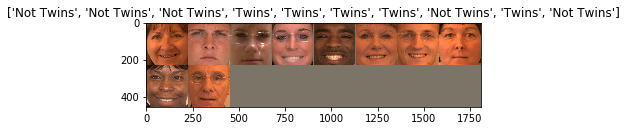

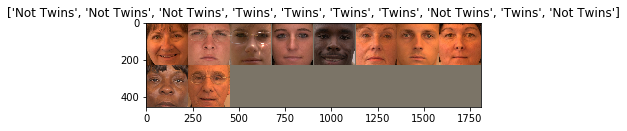

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
img_a,img_b,label = next(iter(dataset))

# Make a grid from batch
out = torchvision.utils.make_grid(img_a)
imshow(out, title=[x for x in label])

out = torchvision.utils.make_grid(img_b)
imshow(out, title=[x for x in label])

In [ ]:
t=0
for _,T in enumerate(dataset):
    img_a,img_b,label=T
    t+=len(label)
print(t)